In [1]:
from PIL import Image
from skimage import measure                       
from shapely.geometry import Polygon, MultiPolygon 
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from Utils.training import iou_np
from Utils.build_dataset import paths_dataset
from Utils.coco_dataset import get_annotations, create_sub_mask_annotation
from torchvision import transforms
from Utils.training import training_loop, predict, iou_np
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.config import get_cfg
from detectron2 import model_zoo
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import cv2
import os

## Construindo o Dataset

In [2]:
path = 'Dataset/Fish_Dataset/Fish_Dataset/'
df_train_pd, df_valid_pd, df_test_pd = paths_dataset(path)

In [3]:
DatasetCatalog.register('fish_train', lambda: get_annotations(df_train_pd))
MetadataCatalog.get('fish_train').set(thing_classes=['fish'])
#fish_metadata = MetadataCatalog.get("fish_train")

namespace(name='fish_train', thing_classes=['fish'])

In [4]:
DatasetCatalog.register('fish_valid', lambda: get_annotations(df_valid_pd))
MetadataCatalog.get('fish_valid').set(thing_classes=['fish'])

namespace(name='fish_valid', thing_classes=['fish'])

In [5]:
DatasetCatalog.register('fish_test', lambda: get_annotations(df_test_pd))
MetadataCatalog.get('fish_test').set(thing_classes=['fish'])

namespace(name='fish_test', thing_classes=['fish'])

## Treinando o Modelo

In [36]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("fish_train",)
cfg.DATASETS.TEST = ("fish_valid",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.0001  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
cfg.OUTPUT_DIR = 'output_detectron2'

In [37]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/20 08:12:24 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[12/20 08:13:28 d2.data.build]: Removed 0 images with no usable annotations. 5400 images left.
[12/20 08:13:28 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    fish    | 5400         |
|            |              |
[12/20 08:13:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[12/20 08:13:28 d2.data.build]: Using training sampler TrainingSampler
[12/20 08:13:28 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/20 08:13:28 d2.data.common]: Serializing 5400 elements to byte tensors and concatenating them all ...
[12/20 08:14:04 d2.data.common]: Serialized dataset takes 5423.01 MiB
[12/20 08:14:04 d2.data.build]: Making batched data loader with batch_size=2
[12/20 08:14:05 d2.checkpoint.detection_checkpoin

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[12/20 08:14:05 d2.engine.train_loop]: Starting training from iteration 0
[12/20 08:14:23 d2.utils.events]:  eta: 0:01:40  iter: 19  total_loss: 1.437  loss_cls: 0.5989  loss_box_reg: 0.1405  loss_mask: 0.6934  loss_rpn_cls: 0.000838  loss_rpn_loc: 0.005418    time: 0.3757  last_time: 0.3841  data_time: 0.4787  last_data_time: 0.0035   lr: 6.427e-06  max_mem: 2420M
[12/20 08:14:35 d2.utils.events]:  eta: 0:01:27  iter: 39  total_loss: 1.279  loss_cls: 0.4853  loss_box_reg: 0.126  loss_mask: 0.6686  loss_rpn_cls: 0.000726  loss_rpn_loc: 0.004942    time: 0.3520  last_time: 0.3118  data_time: 0.0035  last_data_time: 0.0036   lr: 1.3087e-05  max_mem: 2420M
[12/20 08:14:41 d2.utils.events]:  eta: 0:01:16  iter: 59  total_loss: 1.069  loss_cls: 0.3149  loss_box_reg: 0.1402  loss_mask: 0.6173  loss_rpn_cls: 0.000356  loss_rpn_loc: 0.005536    time: 0.3407  last_time: 0.2703  data_time: 0.0035  last_data_time: 0.0032   lr: 1.9747e-05  max_mem: 2420M
[12/20 08:14:48 d2.utils.events]:  eta: 0:0

In [38]:
cfg.OUTPUT_DIR

'output_detectron2'

In [39]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4
predictor = DefaultPredictor(cfg)

[12/20 08:17:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output_detectron2\model_final.pth ...


In [40]:
df_test = get_annotations(df_test_pd)

NameError: name 'fish_metadata' is not defined

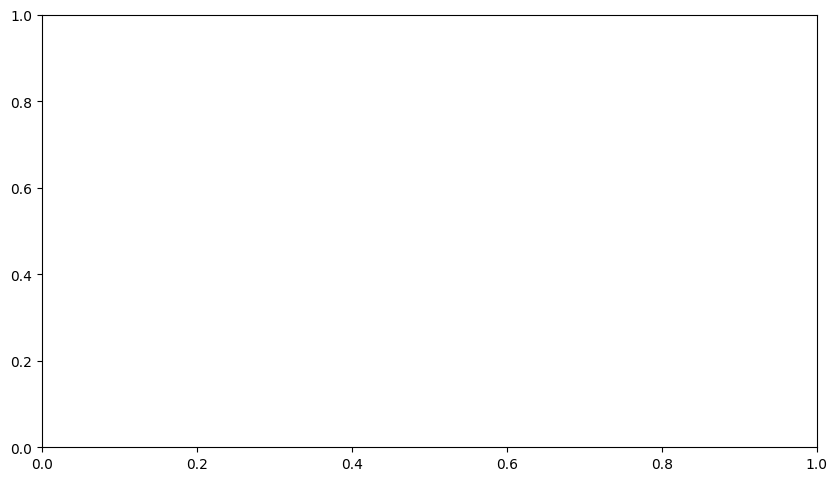

In [41]:
from detectron2.utils.visualizer import ColorMode
for d in random.sample(df_test, 3):
    fig = plt.figure(figsize=(10, 100))
    fig.add_subplot(15, 1, 1)
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=fish_metadata, 
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])

In [42]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("fish_test", output_dir="output_detectron2")
val_loader = build_detection_test_loader(cfg, "fish_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[12/20 08:17:39 d2.evaluation.coco_evaluation]: Trying to convert 'fish_test' to COCO format ...
WARNING [12/20 08:17:39 d2.data.datasets.coco]: Using previously cached COCO format annotations at 'output_detectron2\fish_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[12/20 08:18:00 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/20 08:18:00 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/20 08:18:00 d2.data.common]: Serializing 1800 elements to byte tensors and concatenating them all ...
[12/20 08:18:01 d2.data.common]: Serialized dataset takes 1807.64 MiB
[12/20 08:18:01 d2.evaluation.evaluator]: Start inference on 1800 batches
[12/20 08:18:07 d2.evaluation.evaluator]: Inference done 11/1800. Dataloading: 0.0017 s/iter. Inference: 0.0734 s/iter. Eval: 0.0010 s/iter. 

[12/20 08:20:21 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
[12/20 08:20:21 d2.evaluation.fast_eval_api]: Evaluate annotation type *segm*
[12/20 08:20:22 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.27 seconds.
[12/20 08:20:22 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[12/20 08:20:22 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.569
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.811
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.696
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDet

In [43]:
iou_sum = 0
iou_list = []
for annon in df_test:
    im = cv2.imread(annon['file_name'])
    outputs = predictor(im)
    try:
        pred = outputs['instances'].pred_masks[0]
        pred = pred.to('cpu')
        pred_int = pred.long()
        pred_np = pred_int.numpy()
        iou_pred = iou_np(annon['mask'], pred_np)
    except:
        iou_pred = 0
    iou_sum += iou_pred
    iou_list.append(iou_pred)

iou = (iou_sum / len(df_test)) * 100
print(f'IoU: {iou:.1f}')

IoU: 82.5
